In [68]:
import sys

sys.path.append('..')

import torch
import matplotlib.pyplot as plt
import numpy as np 
import networkx as nx
import seaborn as sns
import pandas as pd

from spikeometric.models import BernoulliGLM
from spikeometric.stimulus import RegularStimulus
from spikeometric.datasets import NormalGenerator, UniformGenerator
from torch_geometric.utils import to_networkx, from_networkx, to_dense_adj

from CD_methods import observational_learner_Poisson, interventional_learner_Poisson
from functions import *

In [69]:
seed=78

# Small networks

In [64]:
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

G = nx.DiGraph()
# confounding and causal interaction
direct = [(1,2)]
bidirect = [(1,2),(2,1)]
independent = [(0,1)]

fork = [(0,1),(0,2)]
collider = [(1,0),(2,0)]
chain = [(1,0),(0,2)]

G.add_nodes_from([0,1,2])
G.add_edges_from(chain)
network = from_networkx(G)
network.W0 = torch.tensor([-30, 30])
spikes = neuron_model.simulate(network,n_steps=10**4)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 17034.41it/s]


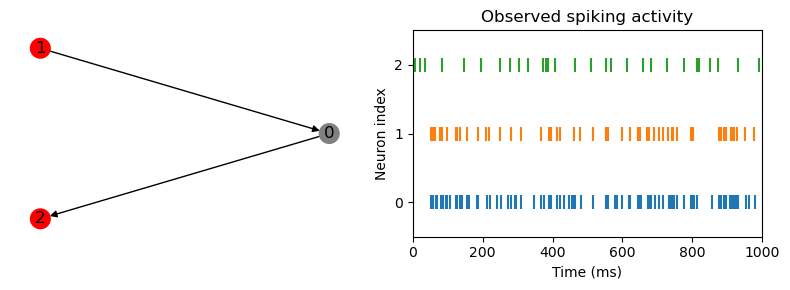

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
nx.draw_circular(G, node_color=['grey','red','red'], with_labels=True,node_size=200,ax=ax[0])
make_rasterplot(spikes)
plt.show()

In [66]:
G_learned_null = observational_learner_Poisson(
        {'null': spikes[[1,2]]}, 
        node_list=[1,2], 
        alpha = 1e-2,)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.26it/s]


In [67]:
print(G_learned_null.edges())

[(1, 2)]


In [7]:
spike_data_dict={}
stimulus_mask = torch.zeros(3, dtype=torch.bool)
stimulus_mask[1]=True
print(stimulus_mask)
neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
spikes_intervention = neuron_model.simulate(network, n_steps=10**4)
spike_data_dict['1'] = spikes_intervention[[1,2]]

stimulus_mask = torch.zeros(3, dtype=torch.bool)
stimulus_mask[2]=True
print(stimulus_mask)
neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
spikes_intervention = neuron_model.simulate(network, n_steps=10**4)
spike_data_dict['2'] = spikes_intervention[[1,2]]

tensor([False,  True, False])


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 17825.32it/s]


tensor([False, False,  True])


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 18108.23it/s]


In [10]:
G_learned = interventional_learner_Poisson(
        spike_data_dict, 
        stimulation_protocol=[[1], [2]],
        SCM_learned=G_learned_null,
        node_list=[1,2], 
        alpha = 1e-2,)

100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 14488.10it/s]


In [11]:
print(G_learned.edges())

[]


# Larger networks

In [129]:
def generate_W0(graph, p, w_exc=1.5, w_inh=-3.0):
    W0 = torch.from_numpy(nx.to_numpy_array(graph))
    n_neurons = graph.number_of_nodes()
    are_excitatory = np.random.choice(n_neurons, size=n_neurons//2, replace=False)
    are_inhibitory = [neuron for neuron in range(n_neurons) if neuron not in are_excitatory]

    for i in are_excitatory:
        for j in range(n_neurons):
            if W0[i, j] == 1:
                W0[i, j] = np.random.beta(a=2,b=2)*w_exc+w_exc/2
    
    for i in are_inhibitory:
        for j in range(n_neurons):
            if W0[i, j] == 1:
                W0[i, j] = np.random.beta(a=2,b=2)*w_inh+w_inh/2
                
    edge_index = W0.nonzero().t()
    W0_ = W0[edge_index[0], edge_index[1]]
    
    return W0_.to(dtype=torch.float32)

In [130]:
def generate_networks(n_networks, p, n_neurons):
    network_data = []
    
    for _ in range(n_networks):
        graph = nx.erdos_renyi_graph(n=n_neurons, p=p, directed=True)
        network = from_networkx(graph)
        network.W0 = generate_W0(graph, p)
        network_data.append(network)
        
    return network_data

In [72]:
n_obs = 10
n_networks = 10
n_timesteps = 10**4

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)
res = {}
plot = False

In [65]:
for n_hidden in [10, 30, 50]:
    res[n_hidden] = {}
    
    for p in [0.1, 0.3, 0.5]:
        res[n_hidden][p] = {'SHD': [], 'sensitivity': [], 'specificity': [], 'F1': []}
        network_data = generate_networks(n_networks, n_neurons=n_obs+n_hidden, p=p)

        for i in range(n_networks):

            network = network_data[i]
            index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))

            spike_data = dict()
            spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)
            spike_data['null'] = spikes[index_obs]

            G = to_networkx(network)   

            if plot:
                node_color = ['red' if node in index_obs else 'grey' for node in G.nodes()]
                fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                nx.draw_networkx(G, arrows=True, ax=ax[0], node_color=node_color, pos=nx.circular_layout(G))
                ax[0].set_title("Full network")
                W0 = to_dense_adj(network.edge_index, edge_attr=network.W0, max_num_nodes=network.num_nodes)[0]
                sns.heatmap(W0, ax=ax[1], annot=False)
                ax[1].set_title("Adjacency matrix")
                ax[1].set_xlabel("Neuron")
                ax[1].set_ylabel("Neuron")
                plt.tight_layout()
                plt.show()

                spikes = spike_data['null']
                plt.figure(figsize=(10,5))
                for i in range(len(index_obs)):
                    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)
                plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
                plt.xlabel("Time (ms)")
                plt.ylabel("Neuron index")
                plt.xlim([0, 1000])
                plt.ylim([-0.5, n_obs - 0.5])
                plt.title("Observed spiking activity")
                plt.tight_layout()
                plt.show()

            G_true = nx.subgraph(G, index_obs)
            G_learned_null = observational_learner_Poisson(
                spike_data, 
                node_list=index_obs, 
                alpha = 1e-2)

            res[n_hidden][p]['SHD'].append(compute_SHD(G_true, G_learned_null))

            tp=count_true_positive(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)
            fp=count_false_positive(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)
            fn=count_false_negative(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)

            res[n_hidden][p]['sensitivity'].append(compute_sensitivity(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
            res[n_hidden][p]['specificity'].append(compute_specificity(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
            res[n_hidden][p]['F1'].append(2*tp/(2*tp+fp+fn))
            #print(res)

100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.59s/it]


In [89]:
n_hidden=50

df = {'SHD': [] , 'sensitivity': [], 'specificity': [], 'F1': []}
rows = []
for p in [0.1, 0.3, 0.5]:
    result_df = pd.DataFrame(res[n_hidden][p])
    print(result_df)
    vals = result_df.mean().round(3)
    sd_vals = result_df.std().round(3)    
    table_row = ['$'+str(vals[i]) + r'\pm' + str(sd_vals[i])+'$' for i in df.keys()]
    rows.append(table_row) 

print(pd.DataFrame(rows).to_latex(escape=False))

   SHD  sensitivity  specificity        F1
0    0          1.0     1.000000  1.000000
1    0          1.0     1.000000  1.000000
2    0          1.0     1.000000  1.000000
3    0          1.0     1.000000  1.000000
4    0          1.0     1.000000  1.000000
5    0          1.0     1.000000  1.000000
6    1          1.0     0.989011  0.947368
7    0          1.0     1.000000  1.000000
8    0          1.0     1.000000  1.000000
9    1          1.0     0.989011  0.947368
   SHD  sensitivity  specificity        F1
0    4     1.000000     0.948718  0.916667
1   11     1.000000     0.867470  0.755556
2    4     1.000000     0.948718  0.916667
3    4     1.000000     0.944444  0.933333
4    3     1.000000     0.961039  0.938776
5    9     1.000000     0.891566  0.790698
6    5     1.000000     0.938272  0.883721
7    4     0.952381     0.962025  0.909091
8    5     0.966667     0.942857  0.920635
9    5     1.000000     0.932432  0.912281
   SHD  sensitivity  specificity        F1
0   14     

In [156]:
import pickle

with open(f'../data/results_10_obs_nodes.pickle','wb') as f:
        pickle.dump(res,f)  

### ROC curves

For $p=0.3$, and $n_\text{hidden}=10,20,30$ we plot ROC curves.
Need to compute avg. sens. and spec. for different sig. levels, maybe something like $\alpha = 0.001, 0.01, 0.05, 0.1, 0.3$

alpha_values = np.logspace()

# Single cell interventions

## Test method for single network

In [139]:
n_obs = 10
n_hidden = 0
p = 0.1
n_networks = 1
n_timesteps = 10**4
network_data = generate_networks(n_networks, n_neurons=n_obs+n_hidden, p=p)
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [140]:
network_data[0].W0

tensor([ 2.0847,  1.7794,  1.0062, -3.8747, -2.9472,  1.0849,  1.6627,  1.3753,
         1.5337,  1.6139,  1.7246, -2.6293])

In [125]:
network = network_data[0]
index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))
alpha = 1e-2

# data generation
stimulation_protocol = [[i] for i in index_obs] # random single node intervention
spike_data = dict()
stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)
spike_data['null'] = spikes[index_obs]

for intervention_set in stimulation_protocol:
    stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
    stimulus_mask[intervention_set] = True
    neuron_model.add_stimulus(lambda t: 3.5*(t % 10 < 3)*stimulus_mask)
    spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)          
    intervention_node = intervention_set[0]
    spike_data[str(intervention_node)] = spikes[index_obs]

G = to_networkx(network)
G_true = nx.subgraph(G, index_obs)

# learn observational
G_learned_null = observational_learner_Poisson(
    spike_data, 
    node_list=index_obs, 
    alpha = alpha)

G_learned = G_learned_null.copy()

for intervention_set in stimulation_protocol:
    intervention_node = intervention_set[0]
    #make_rasterplot(spike_data[str(intervention_node)])
    G_learned = interventional_learner_Poisson(
        spike_data,
        node_list=index_obs, 
        stimulation_protocol=[intervention_set],
        SCM_learned=G_learned,
        alpha = alpha)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.10it/s]


In [126]:
print('alpha =',alpha)
print(compute_sensitivity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))
print(compute_specificity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))
print(compute_SHD(G_learned=G_learned, G_true=G_true))

alpha = 0.01
1.0
0.9789473684210527
2


In [86]:
n_networks=10
n_obs=10
n_timesteps=10**4

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)
res = {}
plot=False

In [87]:
for n_hidden in [10, 30, 50]:    
    res[n_hidden] = {}
        
    for p in [0.1, 0.3, 0.5]:
        res[n_hidden][p] = {'SHD': [], 'sensitivity': [], 'specificity': [], 'F1': []}
        network_data = generate_networks(n_networks, n_neurons=n_obs+n_hidden, p=p)

        for i in range(n_networks):
            network = network_data[i]
            G = to_networkx(network) # full network   
            index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))
            
            if plot:
                node_color = ['red' if node in index_obs else 'grey' for node in G.nodes()]
                fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                nx.draw_networkx(G, arrows=True, ax=ax[0], node_color=node_color, pos=nx.circular_layout(G))
                ax[0].set_title("Full network")
                W0 = to_dense_adj(network.edge_index, edge_attr=network.W0, max_num_nodes=network.num_nodes)[0]
                sns.heatmap(W0, ax=ax[1], annot=False)
                ax[1].set_title("Adjacency matrix")
                ax[1].set_xlabel("Neuron")
                ax[1].set_ylabel("Neuron")
                plt.tight_layout()
                plt.show()
            
            # data generation
            stimulation_protocol = [[i] for i in index_obs] # random single node intervention
            spike_data = dict()
            stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
            spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)
            spike_data['null'] = spikes[index_obs]

            for intervention_set in stimulation_protocol:
                stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
                stimulus_mask[intervention_set] = True
                neuron_model.add_stimulus(lambda t: 3.5*(t % 10 < 3)*stimulus_mask)
                spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)          
                intervention_node = intervention_set[0]
                spike_data[str(intervention_node)] = spikes[index_obs]
            
            G_true = nx.subgraph(G, index_obs)
            
            # learn observational
            G_learned_null = observational_learner_Poisson(
                spike_data, 
                node_list=index_obs, 
                alpha = 1e-5)
            
            G_learned = G_learned_null.copy()
            
            for intervention_set in stimulation_protocol:
                intervention_node = intervention_set[0]

                G_learned = interventional_learner_Poisson(
                    spike_data,
                    node_list=index_obs, 
                    stimulation_protocol=[intervention_set],
                    SCM_learned=G_learned,
                    alpha = 1e-2)
            
            # compute performance metrics
            res[n_hidden][p]['SHD'].append(compute_SHD(G_true, G_learned))
            res[n_hidden][p]['sensitivity'].append(compute_sensitivity(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
            res[n_hidden][p]['specificity'].append(compute_specificity(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
            
            tp = count_true_positive(G_learned=G_learned, G_true=G_true, nodelist=index_obs)
            fp = count_false_positive(G_learned=G_learned, G_true=G_true, nodelist=index_obs)
            fn = count_false_negative(G_learned=G_learned, G_true=G_true, nodelist=index_obs)

            res[n_hidden][p]['F1'].append(2*tp/(2*tp+fp+fn))

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


In [94]:
n_hidden=50

df = {'SHD': [] , 'sensitivity': [], 'specificity': [], 'F1': []}
rows = []
for p in [0.1, 0.3, 0.5]:
    result_df = pd.DataFrame(res[n_hidden][p])
    #print(result_df)
    vals = result_df.mean().round(3)
    sd_vals = result_df.std().round(3)    
    table_row = ['$'+str(vals[i]) + r'\pm' + str(sd_vals[i])+'$' for i in df.keys()]
    rows.append(table_row) 

print(pd.DataFrame(rows).to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
 & 0 & 1 & 2 & 3 \\
\midrule
0 & $0.2\pm0.422$ & $1.0\pm0.0$ & $0.998\pm0.005$ & $0.989\pm0.022$ \\
1 & $5.4\pm2.547$ & $0.992\pm0.017$ & $0.934\pm0.031$ & $0.888\pm0.063$ \\
2 & $15.0\pm6.498$ & $0.986\pm0.018$ & $0.796\pm0.082$ & $0.793\pm0.089$ \\
\bottomrule
\end{tabular}



In [92]:
print(pd.DataFrame(res[50][0.5]))

   SHD  sensitivity  specificity        F1
0   14     1.000000     0.794118  0.820513
1   21     1.000000     0.704225  0.734177
2   20     0.958333     0.750000  0.696970
3   10     1.000000     0.852941  0.864865
4   14     0.971429     0.800000  0.829268
5    6     1.000000     0.915493  0.906250
6    8     1.000000     0.888889  0.875000
7   18     0.961538     0.770270  0.735294
8   27     1.000000     0.649351  0.630137
9   12     0.969697     0.835821  0.842105


In [43]:
import pickle

with open(f'../data/results_10_obs_nodes_int.pickle','wb') as f:
        pickle.dump(res,f)  

TP             18.100
FP              2.600
TN             77.500
FN              1.800
SHD             4.400
sensitivity     0.874
specificity     0.977
F1              0.889
dtype: float64

In [160]:
df.std().round(3)

TP             2.923
FP             1.578
TN             2.550
FN             1.135
SHD            1.955
sensitivity    0.076
specificity    0.014
F1             0.051
dtype: float64

# Plotting

In [82]:
sns.set_theme(palette="colorblind",style="ticks",context='notebook')

cm=1/2.54
params = {
    'legend.fontsize': 12,
    'font.size': 12,
    'figure.figsize': (20*cm,10.0*cm), # figsize for two-column latex doc
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.markersize': 3.0,
    'lines.linewidth': 1.5,
    }

plt.rcParams.update(params)

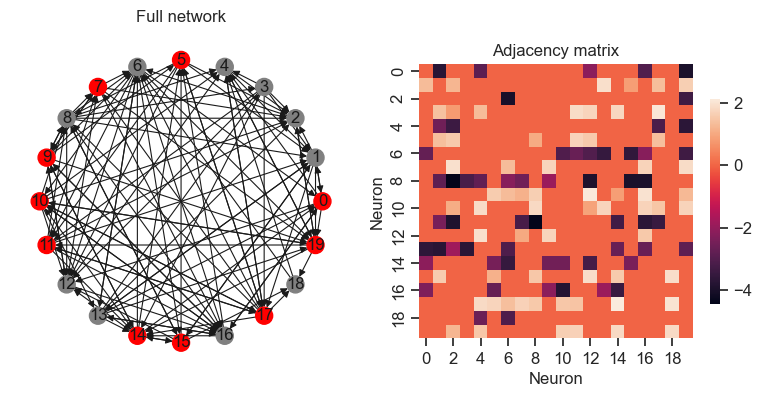

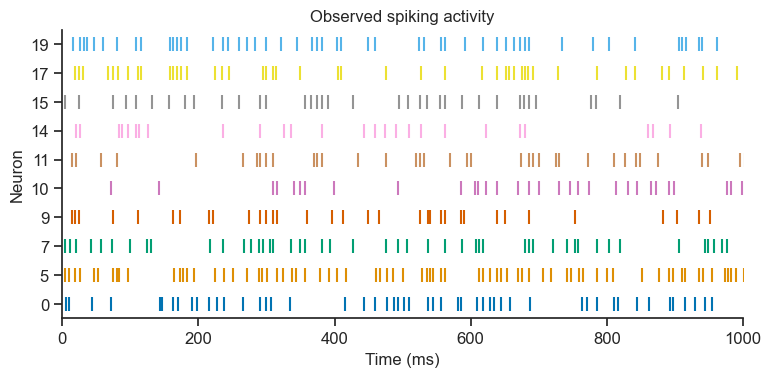

In [91]:
n_hidden=10
p=0.3
network_data = generate_networks(n_networks, n_neurons=n_obs+n_hidden, p=p)
network = network_data[0]
index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))
G = to_networkx(network) # full network 
node_color = ['red' if node in index_obs else 'grey' for node in G.nodes()]

fig, ax = plt.subplots(1, 2)
nx.draw_networkx(
    G, arrows=True, ax=ax[0], node_color=node_color, pos=nx.circular_layout(G), node_size=150, width=0.8,arrowsize=10)
ax[0].set_title("Full network")
ax[0].set_aspect('equal', adjustable='box')

W0 = to_dense_adj(network.edge_index, edge_attr=network.W0, max_num_nodes=network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1], annot=False,square=True,cbar_kws={"shrink": .6})
sns.despine(bottom = True, left = True, top=True,right=True)
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")
plt.tight_layout()
plt.savefig('../figures/rand_netw_20_nodes_p01.pdf')

spikes = spike_data['null']
plt.figure()
for i in range(len(index_obs)):
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)
plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
plt.xlabel("Time (ms)")
plt.ylabel("Neuron")
plt.xlim([0, 1000])
plt.ylim([-0.5, n_obs - 0.5])
plt.title("Observed spiking activity")
sns.despine()
plt.tight_layout()
plt.savefig('../figures/rasterplot_10obs.pdf')


In [24]:
ls = [3,4,5]

In [25]:
ls = set(ls)

In [26]:
indC=ls.difference([3])
import numpy as np

In [27]:
arr=np.array([[1,2,3,4,5,6],[1,2,3,4,5,8]])

In [29]:
arr[0,list(indC)]

array([5, 6])